<a href="https://colab.research.google.com/github/gsarm78/MetaSegmentation/blob/main/FewShot_SatImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Few Shot Satellite Image Object Detection
Circular structure detection in Satellite Images.
Using a pre-trained model (COCO) and finetuning on a RetinaNet architecture on very few examples of a novel class ( in this case circular structures in satellite images) after initializing from a pre-trained COCO checkpoint.


## Setup & Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U --pre tensorflow=="2.2.0"

     |████████████████████████████████| 516.2MB 28kB/s 
     |████████████████████████████████| 3.0MB 54.2MB/s 
     |████████████████████████████████| 460kB 67.4MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [3]:
# Data are renamed with a numbered filename
!unzip /content/drive/My\ Drive/cs330Data/fewshots.zip -d /content/data

Archive:  /content/drive/My Drive/cs330Data/fewshots.zip
  inflating: /content/data/5_image.jpg  
   creating: /content/data/__MACOSX/
  inflating: /content/data/__MACOSX/._5_image.jpg  
  inflating: /content/data/3_image.jpg  
  inflating: /content/data/__MACOSX/._3_image.jpg  
  inflating: /content/data/4_image.jpg  
  inflating: /content/data/__MACOSX/._4_image.jpg  
  inflating: /content/data/2_image.jpg  
  inflating: /content/data/__MACOSX/._2_image.jpg  
  inflating: /content/data/1_image.jpg  
  inflating: /content/data/__MACOSX/._1_image.jpg  
  inflating: /content/data/6_image.jpg  
  inflating: /content/data/__MACOSX/._6_image.jpg  


In [4]:
rm -r /content/data/__MACOSX

In [5]:
!unzip /content/drive/My\ Drive/cs330Data/evaluation.zip -d /content/evaluation



Archive:  /content/drive/My Drive/cs330Data/evaluation.zip
  inflating: /content/evaluation/2_eval.jpeg  
   creating: /content/evaluation/__MACOSX/
  inflating: /content/evaluation/__MACOSX/._2_eval.jpeg  
  inflating: /content/evaluation/4_eval.jpeg  
  inflating: /content/evaluation/__MACOSX/._4_eval.jpeg  
  inflating: /content/evaluation/3_eval.jpeg  
  inflating: /content/evaluation/__MACOSX/._3_eval.jpeg  
  inflating: /content/evaluation/5_eval.jpeg  
  inflating: /content/evaluation/__MACOSX/._5_eval.jpeg  
  inflating: /content/evaluation/8_eval.jpeg  
  inflating: /content/evaluation/__MACOSX/._8_eval.jpeg  
  inflating: /content/evaluation/6_eval.jpeg  
  inflating: /content/evaluation/__MACOSX/._6_eval.jpeg  
  inflating: /content/evaluation/1_eval.jpeg  
  inflating: /content/evaluation/__MACOSX/._1_eval.jpeg  
  inflating: /content/evaluation/7_eval.jpeg  
  inflating: /content/evaluation/__MACOSX/._7_eval.jpeg  


In [6]:
rm -r /content/evaluation/__MACOSX

In [7]:
import os
import pathlib

# Cloning the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2303, done.
remote: Counting objects: 100% (2303/2303), done.
remote: Compressing objects: 100% (1997/1997), done.
remote: Total 2303 (delta 564), reused 962 (delta 283), pack-reused 0
Receiving objects: 100% (2303/2303), 30.58 MiB | 18.76 MiB/s, done.
Resolving deltas: 100% (564/564), done.


In [58]:
# Install Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1598806 sha256=4d027db60b355f9cc7b70b47df7c6fb01da450ceb07ec5d4966ca2a37c39e05a
  Stored in directory: /tmp/pip-ephem-wheel-cache-_p2y3r1n/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [9]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

# Utils

In [56]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.
  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  image_array = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
  return image_array

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """
  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based, and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holdingcategory index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=False,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


# Satellite images - samples to annotate



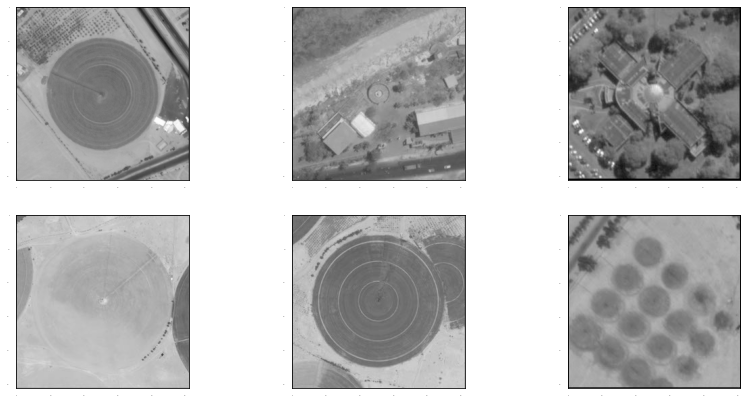

In [54]:
# Load images and visualize
train_image_dir = '/content/data/'
train_images_np = []
for i in range(1, 7):#1,6
  image_path = os.path.join(train_image_dir, str(i) + '_image.jpg')
  
  train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

# Annotate images with bounding boxes





In [55]:
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes) #TODO----Fix IMAGE Compression!

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
#preannotated bounding boxes
'''
gt_boxes = [
             np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
             np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32)
 ]
 '''

# Data prep


In [51]:
#Non-background classes start counting at 1.  
#one class prediction so assign it a class id of 1.
sat_class_id = 1
num_classes = 1

category_index = {sat_class_id: {'id': sat_class_id, 'name': 'circle'}}

#Convert class labels to one-hot; converting everything to tensors.
#`label_id_offset` shifts all classes by a certain number of indices;
#so that the model receives one-hot labels where non-background
#classes start counting at the zeroth index.  
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


Done prepping data.


# visualisation


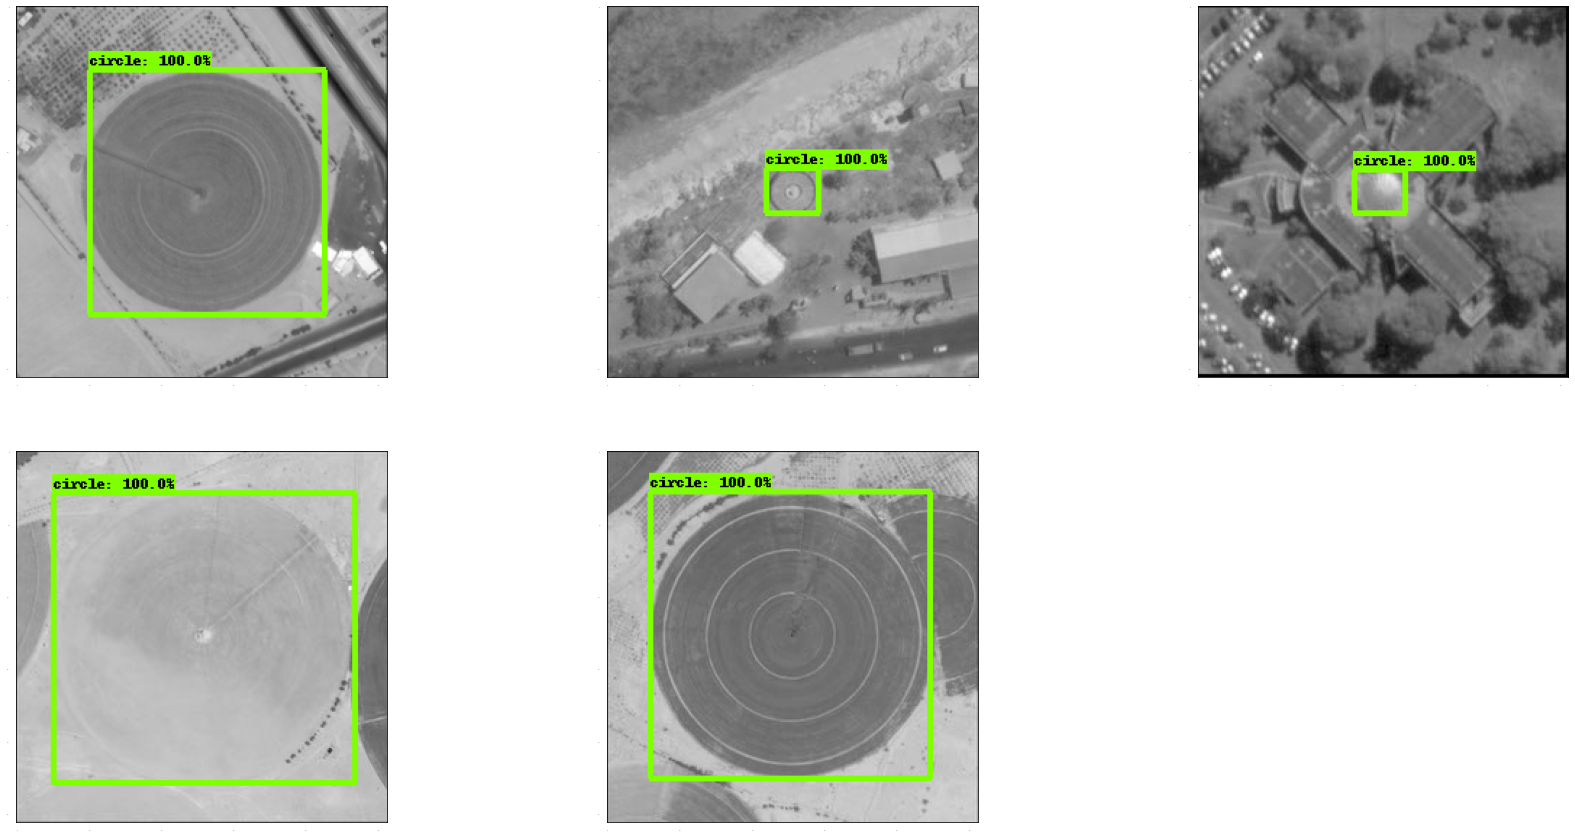

In [52]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100% :)

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),dummy_scores, category_index)
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [88]:
# Download the checkpoint and put it into /content
#model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"

## OD
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint /content

## Segmentation
#!wget http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28.tar.gz
#!tar -xf mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28.tar.gz
#!mv mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28 /content


--2020-11-17 18:06:27--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.79.128, 2a00:1450:4013:c05::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.79.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.5’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   263MB/s    in 0.9s    

2020-11-17 18:06:29 (263 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.5’ saved [244817203/244817203]



In [89]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'

#pipeline_config = '/content/models/research/object_detection/configs/tf2/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.config'
checkpoint_path = '/content/checkpoint/ckpt-0'

#checkpoint_path = '/content/mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28/model.ckpt.data-00000-of-00001'

# Load pipeline config and build a detection model.
# override COCO's `num_classes` field here to one (for Circles in Sat Images)
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.
# Restore the box regression head but initialize the classification head
# from scratch (the omission below shown by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Custom training loop



In [57]:
tf.keras.backend.set_learning_phase(True)

batch_size = 3
learning_rate = 0.001 #0.01
num_batches = 200

# Selecting variables in top layers to finetune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):

  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    ###single training iteration.
    ###image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
    ### reshaping to 640x640.
    ###groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type tf.float32 representing groundtruth boxes for each image in the batch.
    ###groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes] with type tf.float32 representing groundtruth boxes for each image in the batch.

    #Returns: A scalar tensor representing the total loss for the input batch.

    shapes = tf.constant(batch_size * [[256, 256, 3]], dtype=tf.int32)
    #shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32) #for RGB
    #shapes = tf.constant(batch_size * [[640, 640,1]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)


for idx in range(num_batches):
  # Keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Fine-tuning is DONE!')

Start fine-tuning!
batch 0 of 200, loss=1.2945809
batch 10 of 200, loss=0.8173607
batch 20 of 200, loss=0.48595685
batch 30 of 200, loss=0.24860373
batch 40 of 200, loss=0.19319001
batch 50 of 200, loss=0.3717373
batch 60 of 200, loss=0.20212503
batch 70 of 200, loss=0.24289778
batch 80 of 200, loss=0.17328897
batch 90 of 200, loss=0.17030315
batch 100 of 200, loss=0.20898111
batch 110 of 200, loss=0.098227166
batch 120 of 200, loss=0.13369048
batch 130 of 200, loss=0.15061943
batch 140 of 200, loss=0.0810367
batch 150 of 200, loss=0.1570401
batch 160 of 200, loss=0.15138607
batch 170 of 200, loss=0.0921834
batch 180 of 200, loss=0.08613261
batch 190 of 200, loss=0.12405276
Fine-tuning is DONE!


# Load test images and run inference with new model

In [46]:
test_image_dir = '/content/evaluation/'
test_images_np = []
for i in range(1, 8): #seven evaluation images
  image_path = os.path.join(test_image_dir, str(i) + '_eval.jpeg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

@tf.function
def detect(input_tensor):
  #input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  #dict contain 3 tensors (`detection_boxes`, `detection_classes`,and `detection_scores`)
  detection = detection_model.postprocess(prediction_dict, shapes)
  return detection


label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

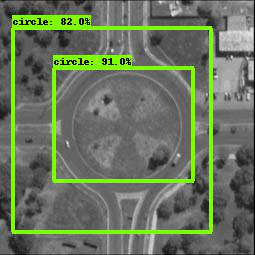

In [47]:
#Create animated gif
imageio.plugins.freeimage.download()

anim_file = 'satImages_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=1)
display(IPyImage(open(anim_file, 'rb').read()))

##Segmentation exp


In [60]:
#Model Loader
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [61]:
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model("mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28")

727392256/727390102 [==============================] - 8s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [62]:
masking_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_masks': TensorShape([None, None, None, None]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

In [64]:
#load sample images
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/content/evaluation/')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpeg")))
TEST_IMAGE_PATHS

[PosixPath('/content/evaluation/1_eval.jpeg'),
 PosixPath('/content/evaluation/2_eval.jpeg'),
 PosixPath('/content/evaluation/3_eval.jpeg'),
 PosixPath('/content/evaluation/4_eval.jpeg'),
 PosixPath('/content/evaluation/5_eval.jpeg'),
 PosixPath('/content/evaluation/6_eval.jpeg'),
 PosixPath('/content/evaluation/7_eval.jpeg')]

In [71]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [72]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(masking_model, image_path)